# Facebook Data Crawling
After the data is collected, we need to process the data to make it more readable and easier to analyze. We can do some simple visualization to see the data distribution and the relationship between the data. We can also do some simple data cleaning to remove the data that is not needed. In this notebook, we will do some simple data processing on the data we collected from Facebook.

In [51]:
%pip install matplotlib pandas numpy seaborn wordcloud

Note: you may need to restart the kernel to use updated packages.


In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.dates as mdates


In [76]:
# Đọc dữ liệu từ tệp CSV
raw_df = pd.read_csv('Data/Data_clean.csv')


In [77]:
# Hiển thị thông tin về dữ liệu
print(raw_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 31 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   post_id                        94 non-null     int64  
 1   post_text                      94 non-null     object 
 2   shared_text                    92 non-null     object 
 3   time                           94 non-null     object 
 4   timestamp                      94 non-null     int64  
 5   image                          1 non-null      object 
 6   image_lowquality               94 non-null     object 
 7   images_lowquality_description  94 non-null     object 
 8   video                          1 non-null      object 
 9   video_id                       1 non-null      float64
 10  video_thumbnail                1 non-null      object 
 11  likes                          94 non-null     int64  
 12  comments                       94 non-null     int64

## Reactions analysis

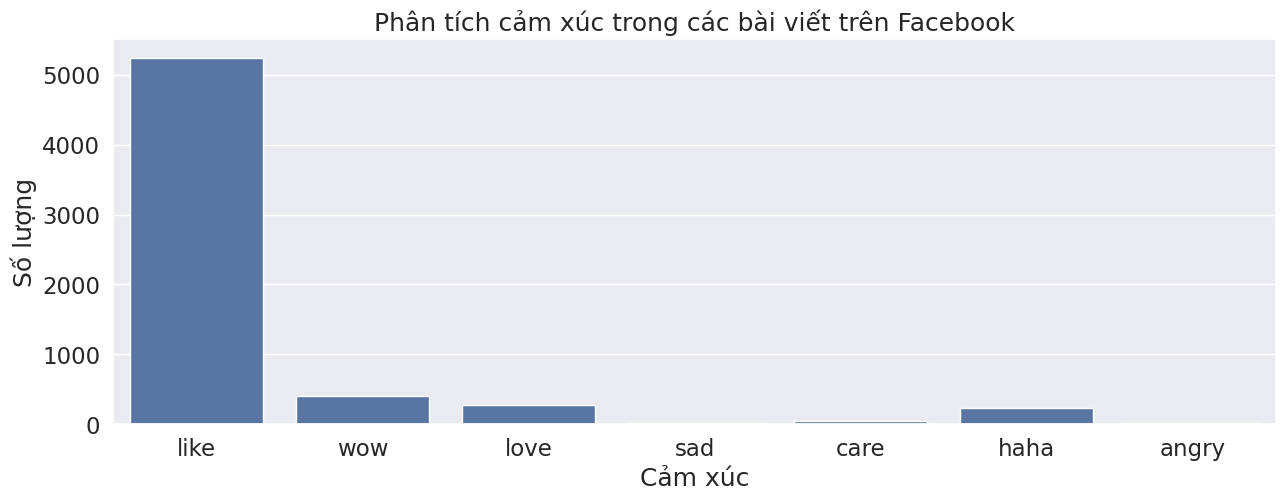

In [78]:
# Chuyển đổi chuỗi trong cột 'reactions' thành từ điển
raw_df['reactions'] = raw_df['reactions'].apply(eval)

# Tính tổng số lượt tương tác cho mỗi bài viết
raw_df['total_interactions'] = raw_df['reactions'].apply(lambda x: sum(x.values())) + raw_df['shares'] + raw_df['comments']

# Tạo DataFrame để lưu trữ thông tin về các loại phản ứng
reaction_df = pd.DataFrame(raw_df['reactions'].tolist())

# Tính tổng số lượt tương tác cho mỗi loại phản ứng
reaction_counts = reaction_df.sum()

# Trực quan hóa số lượng cảm xúc bằng biểu đồ cột
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(15, 5)})
sns.set(font_scale=1.5)

fig, ax = plt.subplots()
ax = sns.barplot(x=reaction_counts.index, y=reaction_counts.values)
ax.set_title("Phân tích cảm xúc trong các bài viết trên Facebook")
ax.set_ylabel("Số lượng")
ax.set_xlabel("Cảm xúc")
plt.xticks(rotation=0)
plt.show()


## Comment and Share analysis


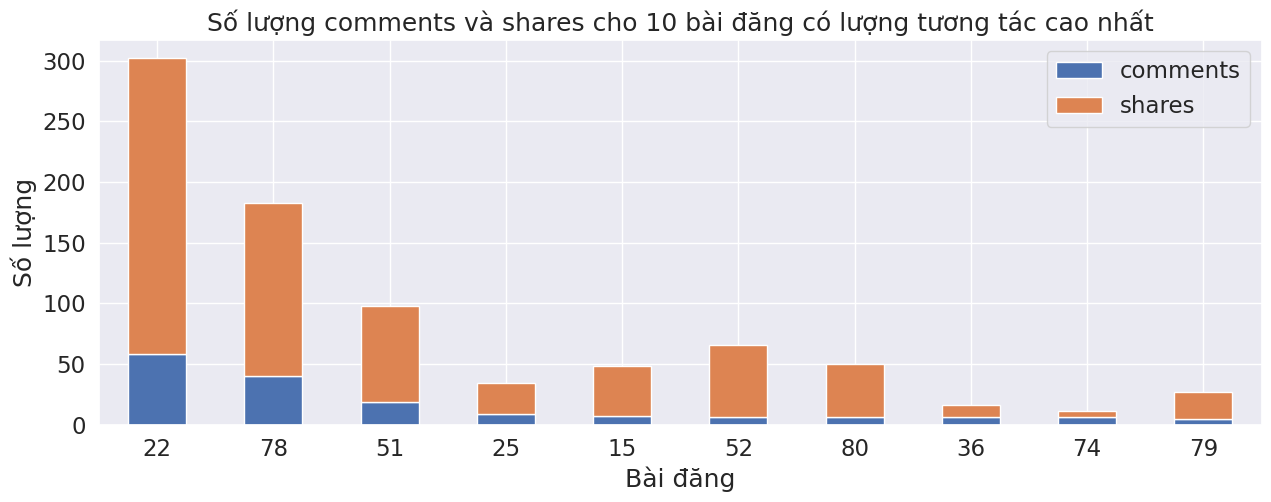

In [79]:
# Lấy 10 bài đăng có số lượng comments và shares cao nhất
top_comments_shares_df = raw_df[['comments', 'shares']].nlargest(10, ['comments', 'shares'])

# Vẽ biểu đồ
top_comments_shares_df.plot(kind='bar', stacked=True)
plt.title("Số lượng comments và shares cho 10 bài đăng có lượng tương tác cao nhất")
plt.ylabel("Số lượng")
plt.xlabel("Bài đăng")
plt.xticks(rotation=0)
plt.show()



Số lượng bài đăng theo thời gian đăng:
post_time
Morning      51
Afternoon    41
0             2
Name: count, dtype: int64


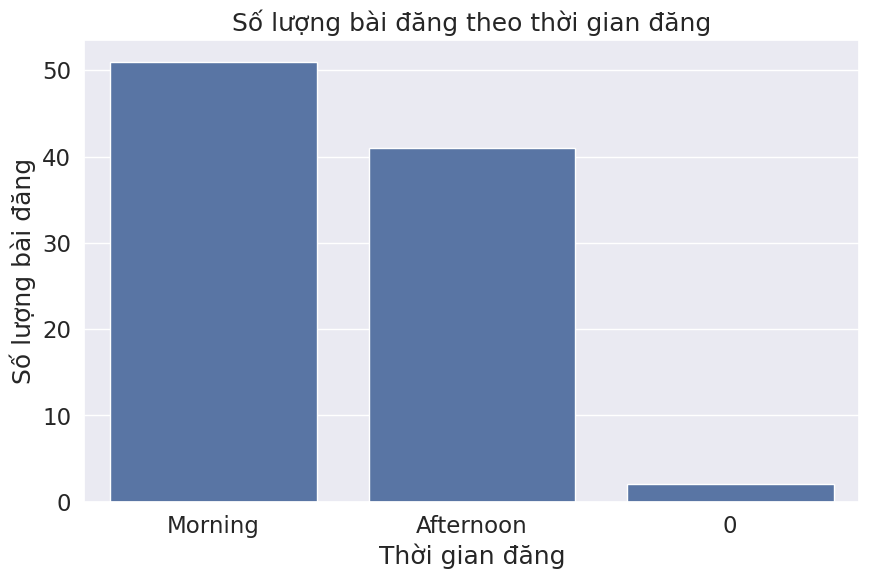

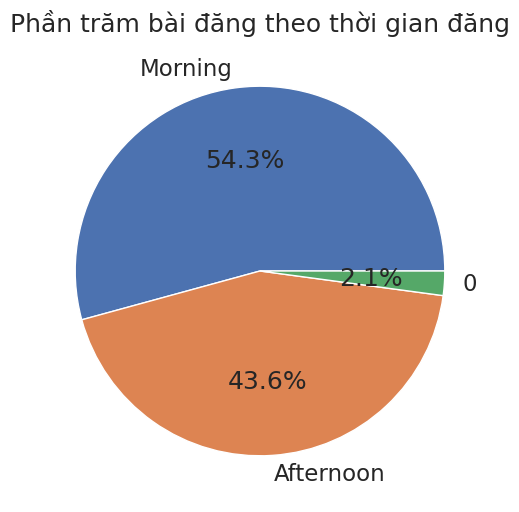

In [81]:
# Chuyển đổi thời gian đăng từ chuỗi sang đối tượng datetime
raw_df['time'] = pd.to_datetime(raw_df['time'])

# Tạo một cột mới 'post_time' dựa trên giờ đăng bài
raw_df['post_time'] = (raw_df['time'].dt.hour % 24 + 4) // 8
raw_df['post_time'].replace({1: 'Morning', 2: 'Afternoon', 3: 'Night'}, inplace=True)

# Tính số lượng bài đăng theo thời gian đăng
post_time_counts = raw_df['post_time'].value_counts()

# In kết quả
print("Số lượng bài đăng theo thời gian đăng:")
print(post_time_counts)

# Vẽ biểu đồ cột
plt.figure(figsize=(10, 6))
sns.barplot(x=post_time_counts.index, y=post_time_counts.values)
plt.title('Số lượng bài đăng theo thời gian đăng')
plt.xlabel('Thời gian đăng')
plt.ylabel('Số lượng bài đăng')
plt.show()

# Vẽ biểu đồ đường tròn
plt.figure(figsize=(10, 6))
plt.pie(post_time_counts.values, labels=post_time_counts.index, autopct='%1.1f%%')
plt.title('Phần trăm bài đăng theo thời gian đăng')
plt.show()


Số lượng phản ứng theo thời gian đăng:
    like  wow  love  sad  care  haha  angry
0      4  1.0   NaN  NaN   NaN   NaN    NaN
1     19  4.0   NaN  NaN   NaN   NaN    NaN
2      6  NaN   1.0  NaN   NaN   NaN    NaN
3     25  8.0   1.0  NaN   NaN   NaN    NaN
4      4  NaN   NaN  NaN   NaN   NaN    NaN
..   ...  ...   ...  ...   ...   ...    ...
89    14  2.0   NaN  NaN   NaN   NaN    NaN
90    22  3.0   NaN  NaN   NaN   NaN    NaN
91    29  NaN   4.0  NaN   NaN   1.0    NaN
92    16  1.0   NaN  NaN   NaN   NaN    NaN
93    84  1.0  11.0  1.0   NaN   1.0    NaN

[94 rows x 7 columns]


<Figure size 1000x600 with 0 Axes>

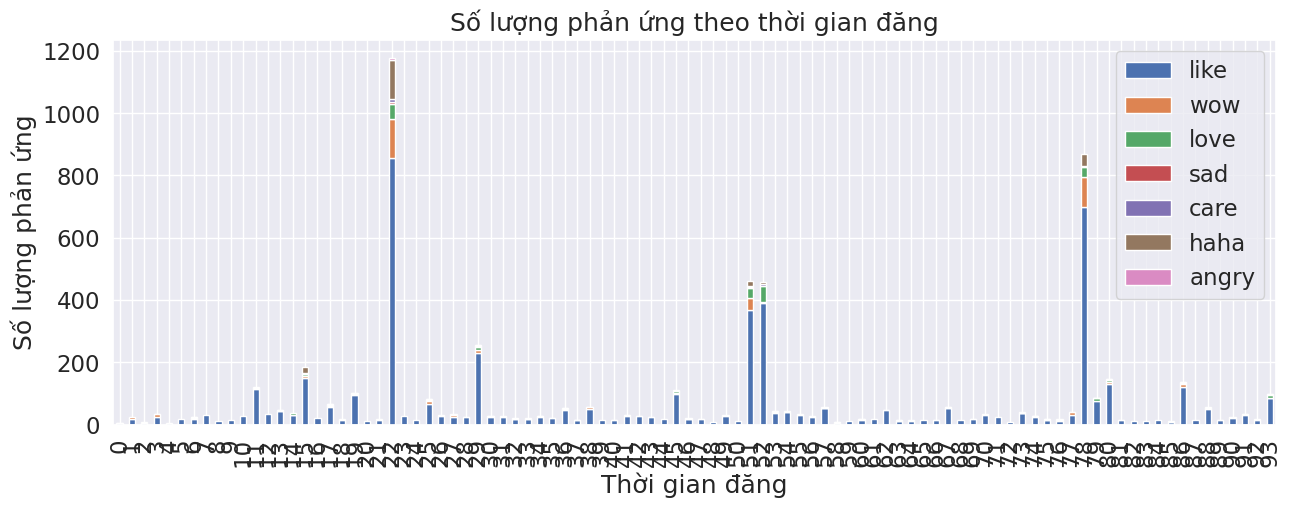

In [73]:
# Tạo một DataFrame mới để lưu trữ số lượng phản ứng theo thời gian đăng
vreaction_df = raw_df.groupby('post_time')[['likes', 'comments', 'shares']].sum()


# In kết quả
print("Số lượng phản ứng theo thời gian đăng:")
print(reaction_df)

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
reaction_df.plot(kind='bar', stacked=True)
plt.title('Số lượng phản ứng theo thời gian đăng')
plt.xlabel('Thời gian đăng')
plt.ylabel('Số lượng phản ứng')
plt.show()


## Read all posts

In [27]:
# Đọc tất cả các bài đăng
text = ' '.join(raw_df['post_text'])

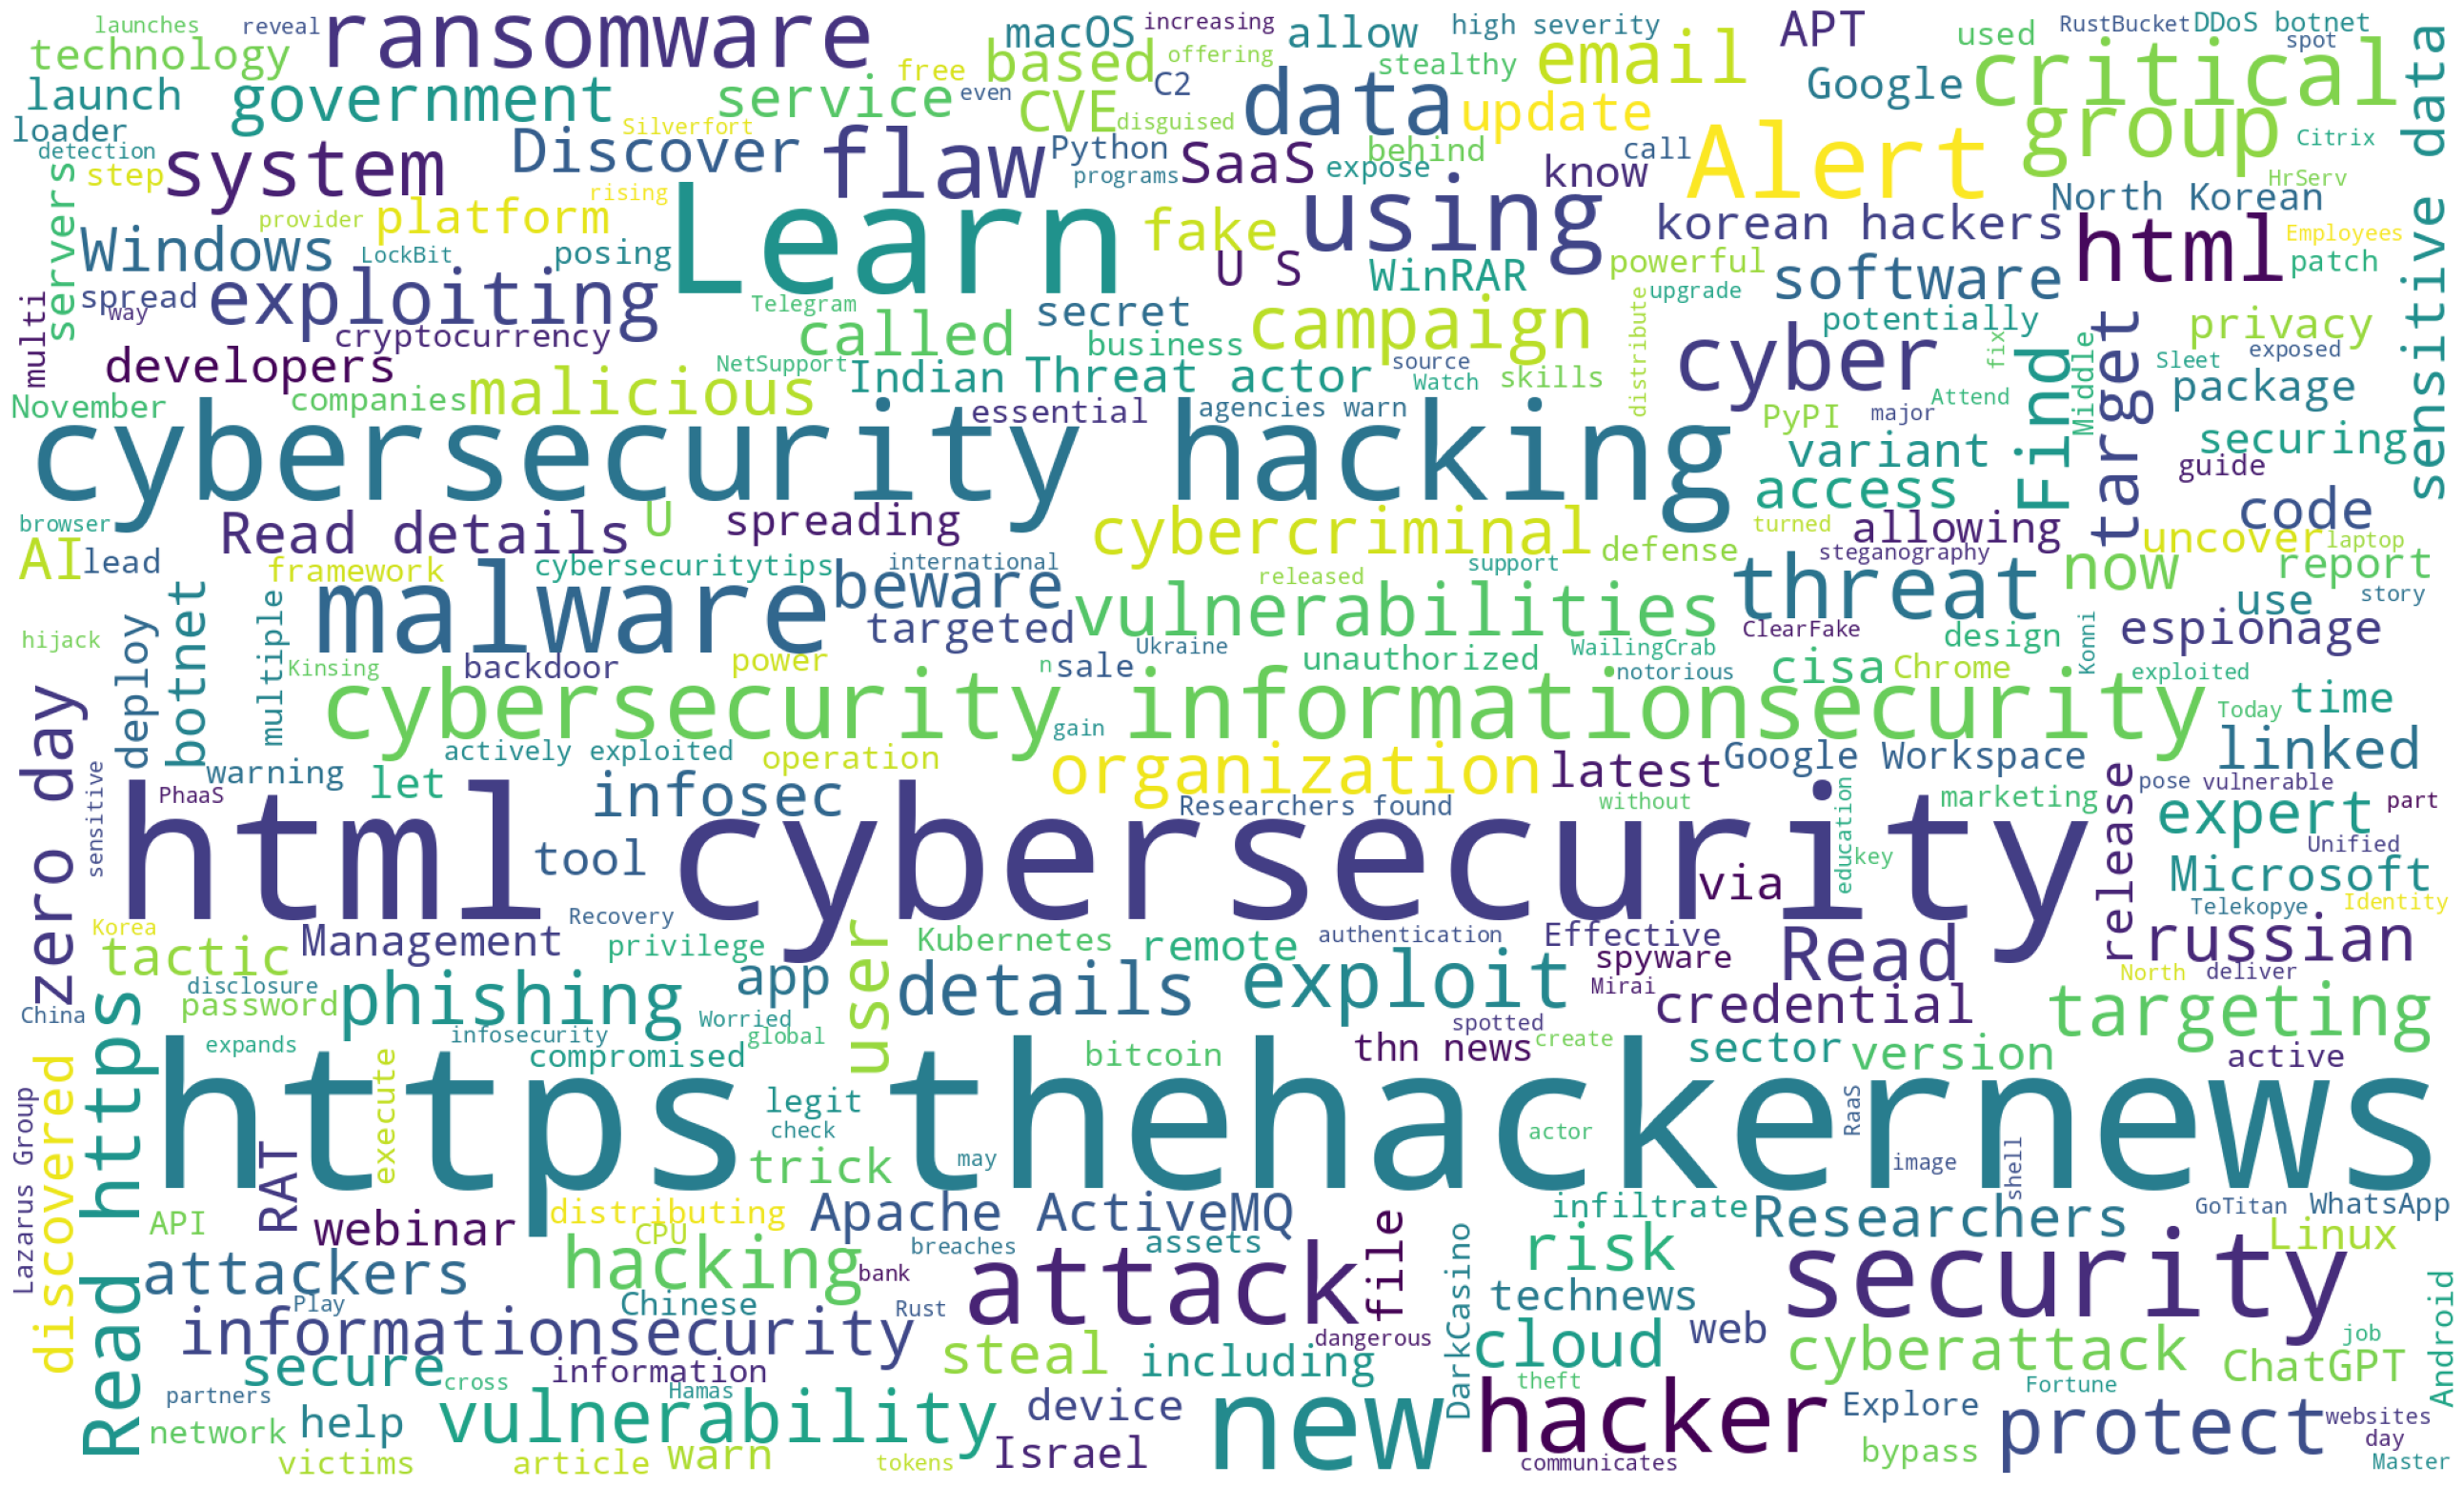

In [17]:
# Tạo WordCloud
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='white', 
                      max_words=300,
                      width=2000, height=1200
                     ).generate(text)
plt.figure(figsize=(40,20))
plt.clf()
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

## Analysis all posts

In [31]:
# TÌM BÀI VIẾT CÓ TƯƠNG TÁC CAO NHẤT
max_interaction_post = raw_df.loc[raw_df['total_interactions'].idxmax()]
print("Bài viết có lượt tương tác lớn nhất:\n", max_interaction_post)

Bài viết có lượt tương tác lớn nhất:
 post_id                                                            716395683858351
post_text                        🔒 Multiple vulnerabilities have been discovere...
shared_text                      THEHACKERNEWS.COM\nNew Flaws in Fingerprint Se...
time                                                           2023-11-22 15:24:23
timestamp                                                               1700666663
image                                                                          NaN
image_lowquality                 https://external.fhan17-1.fna.fbcdn.net/emg1/v...
images_lowquality_description                                               [None]
video                                                                          NaN
video_id                                                                       NaN
video_thumbnail                                                                NaN
likes                                            

In [39]:
# Lấy 10 bài viết có số lượng tương tác cao nhất
top_interactions_df = raw_df.nlargest(10, 'total_interactions')

# In thông tin của 10 bài viết này, bao gồm cả URL
for index, row in top_interactions_df.iterrows():
    print(f"Post ID: {row['post_id']}")
    print(f"Text: {row['post_text']}")  # Sửa ở đây
    print(f"Comments: {row['comments']}")
    print(f"Shares: {row['shares']}")
    print(f"Interactions: {row['total_interactions']}")
    print(f"URL: {row['post_url']}")
    print("\n")


Post ID: 716395683858351
Text: 🔒 Multiple vulnerabilities have been discovered in laptop fingerprint sensors, potentially allowing attackers to bypass Windows Hello authentication on Dell, Lenovo, and Microsoft laptops.

Find out more: https://thehackernews.com/2023/11/new-flaws-in-fingerprint-sensors-let.html

#cybersecurity #hacking #privacy
Comments: 58
Shares: 244
Interactions: 1480
URL: https://facebook.com/thehackernews/posts/716395683858351


Post ID: 709029964594923
Text: Attention Azure users! Researchers have developed a fully undetectable cloud-based #cryptocurrency miner that can operate without paying any charges.

Get the details here: https://thehackernews.com/2023/11/researchers-uncover-undetectable-crypto.html

#cybersecurity #technology #hacking #informationsecurity
Comments: 40
Shares: 143
Interactions: 1051
URL: https://facebook.com/thehackernews/posts/709029964594923


Post ID: 712476564250263
Text: Intel releases critical fixes for a high-severity CPU #vulnerabili

Các mốc thời gian trong ngày mà Fanpage  đăng bài viết:

    time (hour)  count
0             3      2
1             4      6
2             5      8
3             6      6
4             7      7
5             8      3
6             9      3
7            10     10
8            11      8
9            12     16
10           13     13
11           14      3
12           15      4
13           16      3
14           17      2


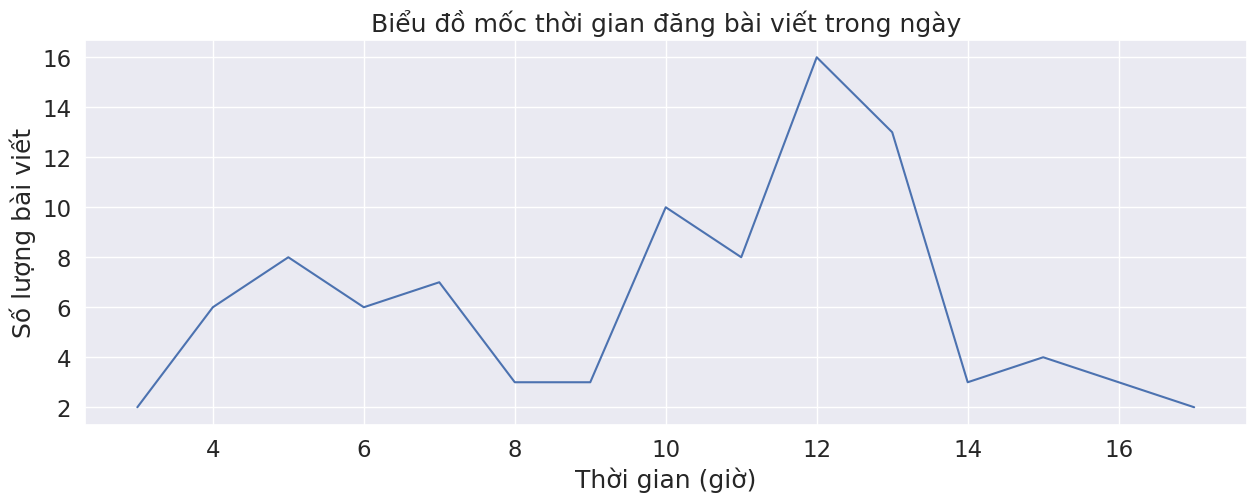

In [40]:
# THÔNG TIN  MỐC THỜI GIAN ĐĂNG BÀI 

# Chuyển đổi cột 'time' thành định dạng datetime
raw_df['time'] = pd.to_datetime(raw_df['time'])

# Tạo cột 'hour' từ cột 'time'
raw_df['hour'] = raw_df['time'].dt.hour

# Tính tổng số bài viết theo giờ
hourly_posts = raw_df['hour'].value_counts().sort_index()

# Tạo DataFrame mới với hai cột là 'time' và 'count'
hourly_posts_df = pd.DataFrame({'time (hour)': hourly_posts.index, 'count': hourly_posts.values})

print("Các mốc thời gian trong ngày mà Fanpage  đăng bài viết:\n")
print(hourly_posts_df)

# Vẽ biểu đồ
plt.plot(hourly_posts_df['time (hour)'], hourly_posts_df['count'])
plt.xlabel('Thời gian (giờ)')
plt.ylabel('Số lượng bài viết')
plt.title('Biểu đồ mốc thời gian đăng bài viết trong ngày')
plt.show()

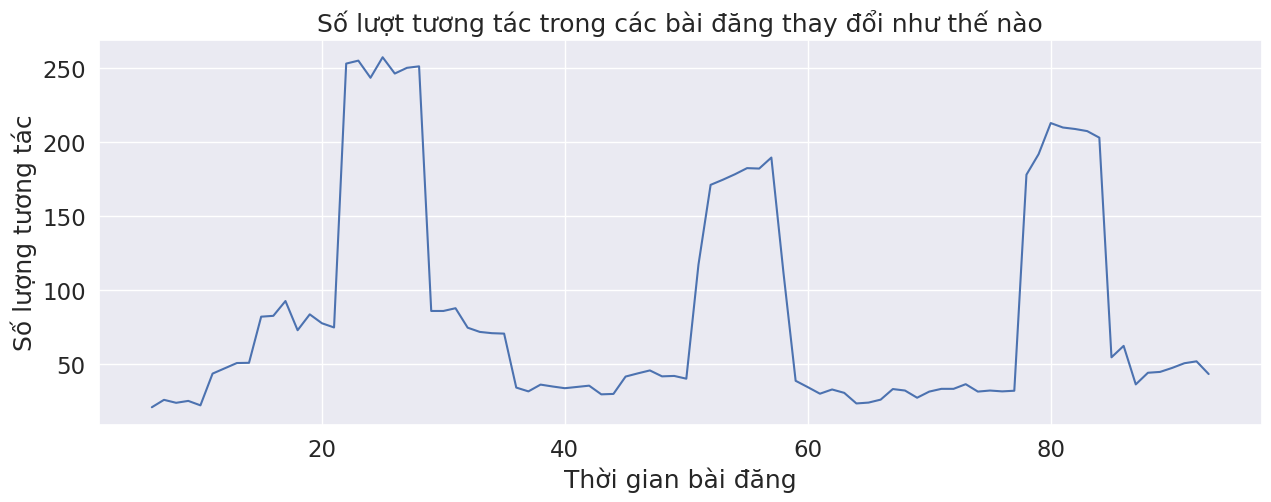

In [41]:
# XEM SỐ LƯỢT TƯƠNG TÁC TRONG CÁC BÀI ĐĂNG BIẾN ĐỔI NHƯ THẾ NÀO

interaction_trend = raw_df['total_interactions'].rolling(window=7).mean()
interaction_trend.plot()
plt.title("Số lượt tương tác trong các bài đăng thay đổi như thế nào")
plt.xlabel("Thời gian bài đăng")
plt.ylabel("Số lượng tương tác")
plt.show()

/home/codespace/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128680 (\N{POLICE CARS REVOLVING LIGHT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


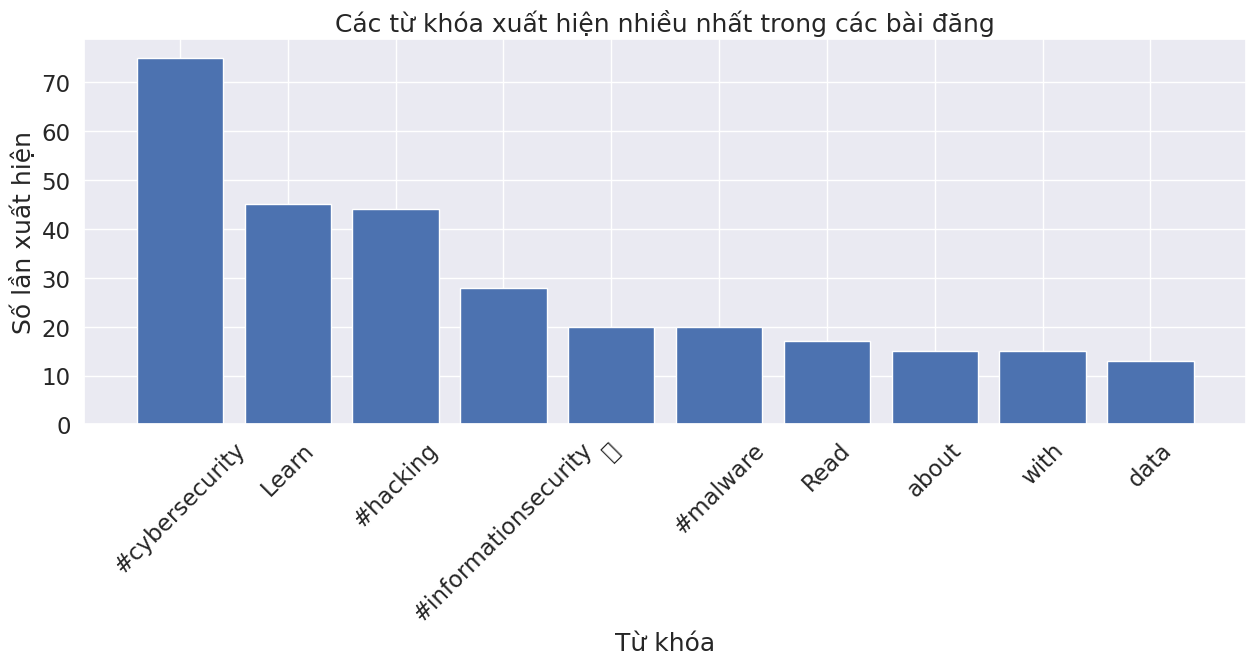

In [42]:
#TÌM TỪ KHÓA XUẤT HIỆN NHIỀU NHẤT

# Danh sách các từ không mong muốn
stopwords = ['and', 'to', 'a',  'in','the', 'more', 'your','of', 'more:', 'how', 'on:', 'for','on', 'is', 'read','are']

# Tính toán số lần xuất hiện của từng từ
word_counts = Counter(word for word in ' '.join(raw_df['post_text']).split() if word not in stopwords)

# Lấy ra 10 từ xuất hiện nhiều nhất
most_common_words = word_counts.most_common(10)

# Tạo DataFrame mới từ danh sách các từ khóa xuất hiện nhiều nhất
most_common_words_df = pd.DataFrame(most_common_words, columns=['Từ khóa', 'Số lần xuất hiện'])

# Vẽ biểu đồ cột
plt.bar(most_common_words_df['Từ khóa'], most_common_words_df['Số lần xuất hiện'])
plt.xlabel('Từ khóa')
plt.ylabel('Số lần xuất hiện')
plt.title('Các từ khóa xuất hiện nhiều nhất trong các bài đăng')
plt.xticks(rotation=45)
plt.show()


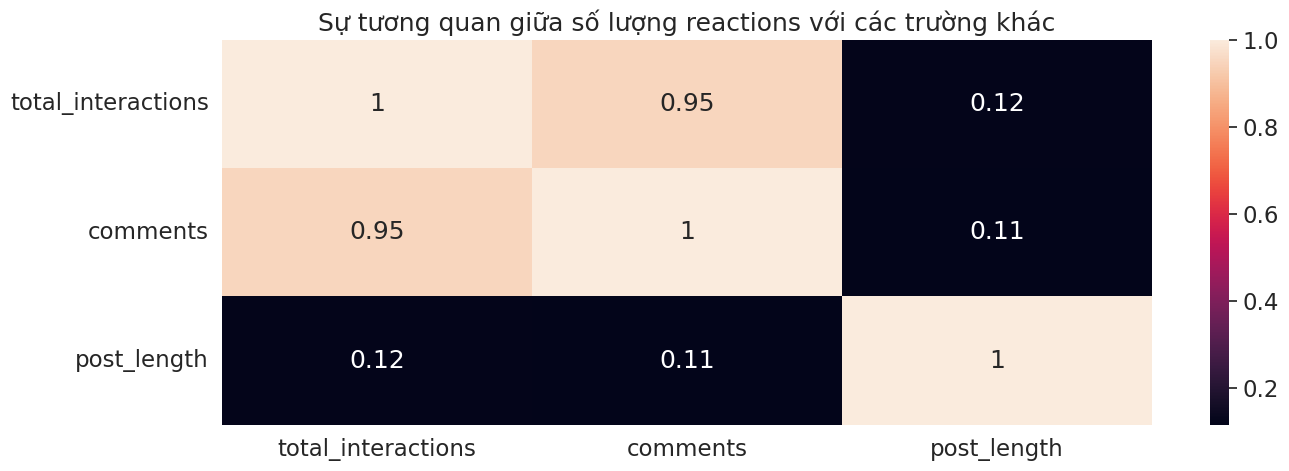

In [43]:
# Tạo một cột mới 'post_length' là độ dài của 'post_text'
raw_df['post_length'] = raw_df['post_text'].apply(len)

# Tìm sự tương quan giữa số lượng reactions với các trường khác như số lượng bình luận, độ dài bài viết
correlation_matrix = raw_df[['total_interactions', 'comments', 'post_length']].corr()
sns.heatmap(correlation_matrix, annot=True)
plt.title("Sự tương quan giữa số lượng reactions với các trường khác")
plt.show()

In [44]:


# Tạo một đối tượng CountVectorizer
vectorizer = CountVectorizer(max_features=1000)

# Chuyển đổi chuỗi văn bản thành ma trận đếm từ
X = vectorizer.fit_transform(raw_df['post_text'])
feature_names = vectorizer.get_feature_names_out()

# Chuyển đổi ma trận đếm từ thành DataFrame
dense = X.todense()
df = pd.DataFrame(dense, columns=feature_names)

print("Đếm từ cho mỗi bài đăng:\n", df)

Đếm từ cho mỗi bài đăng:
     000  10  11  16  17  2022  2023  20592  213  22  ...  worried  wrong  \
0     0   0   1   0   0     0     2      0    0   0  ...        0      0   
1     0   0   1   0   0     0     2      0    0   0  ...        0      0   
2     0   0   1   0   0     0     1      0    0   0  ...        1      0   
3     0   0   1   0   0     0     1      0    0   0  ...        0      0   
4     0   0   0   0   0     0     1      0    0   0  ...        0      0   
..  ...  ..  ..  ..  ..   ...   ...    ...  ...  ..  ...      ...    ...   
89    0   0   1   0   0     0     1      0    0   0  ...        0      0   
90    0   0   1   0   0     0     1      0    0   0  ...        0      0   
91    0   0   1   0   0     0     1      0    0   0  ...        0      0   
92    0   0   1   0   0     0     1      0    0   0  ...        0      0   
93    0   0   1   0   0     0     1      0    0   0  ...        0      0   

    wxpert  xm  you  your  yours  yourself  zero  zimbra  
0 

In [45]:
# Phân tích cảm xúc
raw_df['polarity'] = raw_df['post_text'].apply(lambda x: TextBlob(x).sentiment.polarity)
raw_df['subjectivity'] = raw_df['post_text'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
print("Cảm xúc trung bình của các bài đăng:\n", raw_df[['polarity', 'subjectivity']].mean())

Cảm xúc trung bình của các bài đăng:
 polarity        0.164102
subjectivity    0.510244
dtype: float64


In [47]:
# Tạo một danh sách các cụm từ liên quan đến học hack
keywords = ["learn cybersecurity", "learn ethical hacker", "learn hacking", "hacking course", "cybersecurity course","learn","ceh"]

# Tìm tất cả các bài viết có chứa ít nhất một trong các cụm từ trên
related_posts_df = raw_df[raw_df['post_text'].apply(lambda x: any(keyword in x for keyword in keywords))]

# In thông tin của các bài viết này, bao gồm cả URL
for index, row in related_posts_df.iterrows():
    print(f"Post ID: {row['post_id']}")
    print(f"Text: {row['post_text']}")  # Sửa ở đây
    print(f"Comments: {row['comments']}")
    print(f"Shares: {row['shares']}")
    print(f"Interactions: {row['total_interactions']}")
    print(f"URL: {row['post_url']}")
    print("\n")


Post ID: 712659784231941
Text: U.S. Government Dismantles Global IPStorm Botnet Network!

From Windows to #Linux, Mac, and #Android, the botnet turned infected devices into proxies for illegal activities.

Click to learn more: https://thehackernews.com/2023/11/us-takes-down-ipstorm-botnet-russian.html

#malware #cybersecurity #hacking
Comments: 2
Shares: 7
Interactions: 28
URL: https://facebook.com/thehackernews/posts/712659784231941


